# A guide to build an ANN with Tensorflow

First, let's see how Tensorflow works by a simple example.

In [1]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt

## Define Variables and Constants
Before defining the operations, we need to define the variables and constants may be involved in those operations first.
* The definition of constant in Tensorflow：in tensorflow, we just use the **tf.constant(init, name='xxx')** to define a constant where **init** is the value of that constant, and **name** is the name string of the constant.

In [2]:
a = tf.constant(2, name = 'cons')

* The definition of variables with initial value: in tensorflow, if we want to define a variable and we know its initial value then we can initialize it usin the function **tf.Variable(init, name='xxx')** where **init** is the initial value of the variable and **name** is an optional string name of that variable.

In [3]:
b = tf.Variable(2, name = 'b')
c = tf.Variable(1, name = 'c')

* The definition of variables with out initial value: if we want to define some Tensorflow variables, and we don't know the initial value of those variables yet, then we need to define a variable container. The Tensorflow function **tf.placeholder(dtype, size, name)** will give us a tensor objec without initial values. **dtype** denote the data type of the elements in Tensor object(variable), **size** defines the size of the tensor and **name** of course denotes the string name of the Tensor object(variable).

In [4]:
x = tf.placeholder(tf.float32, [None, 1], name = 'x')

Let's take a look at the **size** parameter here in the function **tf.placeholder()**. The **size** is a list with the structure **[batchSize, dataSize]**, so **None** in the example above is actually the batch size which means we can set the batch size to any number and **1** is the data size which means that the inputs to later operations are a series(batch) of scalars.

## Define Operations
We want them to do some calculations using the variables and constants defined above and derive some outputs. So we need to define those operation next.

In [5]:
op1 = tf.add(a, b, name = 'op1')
op2 = tf.add(a, c, name = 'op2')
op3 = tf.multiply(op1, op2, name = 'output')

In the operations above, we set three operations to perform $(a + b)(a + c)$.

Now it's time to run these operations and derive our outputs. But before that, we need to initialize our variables, constants and operations defined above.

In [6]:
init = tf.global_variables_initializer()

To run the operations between the variables, we need to start a TensorFlow session – tf.Session.  The TensorFlow session is an object where all operations are run. 

In [7]:
with tf.Session() as sess:
    # run initialization
    sess.run(init)
    # compute the output
    output = sess.run(op3)
    print("Variable op3 is %d"%(output))

Variable op3 is 12


Here you can see that we don't need to run **op1** and **op2** manually, we only have to run the final operation **op3**, Tensorflow will automatically find out what other operations it depends on, and will run them before running **op3**. And finally we get the correct answer we wanted: $(1+2)\times(2+2) = 12$

## Using batch for multiple inputs
We can actually feed multiple inputs to the operations at the same time and gets multiple outputs. We can do this by the aforementioned **tf.placeholder**. 

Now we want to perform the same operations defined above, but this time, there will be multiple **b** inputs feed into the operation.

First, define the variables and constants.

In [8]:
a = tf.constant(2, name = 'cons')
b = tf.placeholder(tf.int32, [None, 1], name = 'b')
c = tf.Variable(1, name = 'c')

Define operations.

In [9]:
op1 = tf.add(a, b, name = 'op1')
op2 = tf.add(a, c, name = 'op2')
op3 = tf.multiply(op1, op2, name = 'output')
init = tf.global_variables_initializer()

Run operations with **tf.Session()**. As mentioned before, the variable **b** defined by **tf.placeholder** doesn't have inital values, so we need to feed in the values before we run operations.

In [10]:
b_val = np.arange(0, 5)[:, np.newaxis]
with tf.Session() as sess:
    # run initialization
    sess.run(init)
    # compute the output
    output = sess.run(op3, feed_dict = {b: b_val})
    print('The inputs b is:')
    print(sess.run(b, feed_dict = {b: np.arange(0, 5)[:, np.newaxis]}))
    print("Variable op3 is:")
    print(output)

The inputs b is:
[[0]
 [1]
 [2]
 [3]
 [4]]
Variable op3 is:
[[ 6]
 [ 9]
 [12]
 [15]
 [18]]


The **[:, np.newaxis]** actually turns a (5, ) sized numpy ndarray to size (5, 1). 5 inidicates that there are 5 samples in one batch, and 1 indicates that the input to the operations are scalars. Let's take a look at how the np.newaxis works.

In [11]:
a = np.arange(10)
print(a.shape)
b = a[:, np.newaxis]
print(b.shape)

(10,)
(10, 1)


In [12]:
a = np.array([1,2,3,4,5])
print(a.shape)
b = a[np.newaxis, :]
print(b.shape)

(5,)
(1, 5)


# Set up a three layer ANN with Tensorflow
Now we know how the tensorflow works, we will then set up a three layer Artificial Neural Network using Tensorflow.

Again, we will use the famous **MNIST** digits dataset to test our ANN. Detials of the dataset can be find in Notebook **A comprehensive guide to learn BP Artificail Neural Networks**. 

Since each digits in **MNIST** is represented by a $(8\times8)$ image, the inputs to the ANN would be vectors of length $8\times8 = 64$. The number of hidden layer neurons would be 32. And the output would be a vector of length 10, each element of which represents the probability of the image being that specific digits. 

### First things first, define the variables in the ANN:

In [13]:
X = tf.placeholder(tf.float32, [None, 64], name = 'X')
y = tf.placeholder(tf.float32, [None, 10], name = 'y')

W1 = tf.Variable(tf.random_normal([64, 32], stddev = 0.03), name = 'W1')
b1 = tf.Variable(tf.random_normal([32]), name = 'b1')

W2 = tf.Variable(tf.random_normal([32, 10], stddev = 0.03), name = 'W2')
b2 = tf.Variable(tf.random_normal([10]), name = 'b2')

### Define the operations in the ANN

In [14]:
hidden_output = tf.nn.relu(tf.add(tf.matmul(X, W1), b1))
y_ = tf.nn.softmax(tf.add(tf.matmul(hidden_output, W2), b2))

### Define the cost funtion
We use the cross entropy of the predicted probability vector **$y_\_$** and the actual one-hot vector **$y$** as the cost function. Cross-entropy loss, or log loss, measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. So predicting a probability of .012 when the actual observation label is 1 would be bad and result in a high loss value. A perfect model would have a log loss of 0.

$$J = -\frac{1}{m}\sum_{i=1}^m\sum_{j=1}^n y_i^{(j)}log(y_{i\_}^{(j)})+(1-y_i^{(j)})log(1-y_{i\_}^{(j)})$$
Where **$m$** is the batch size and **$n$** is the size of output.

As you can see, there is $log(y_\_)$ and $log(1-y_\_)$ in the cost function, so the elements in the predicted probability vector can not be either 0 or 1, so we need to limit **$y_\_$** in range $(0, 1)$ using the Tensorflow fucntion **tf.clip_by_value(tensor, min, max)**. Any values less than **min** are set to **min**. Any values greater than **max** are set to **max**.

In [15]:
y_clipped = tf.clip_by_value(y_, 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)
                         + (1 - y) * tf.log(1 - y_clipped), axis=1))

### Set optimiser
Tensorflow provides us a series of neural network training optimsers in https://www.tensorflow.org/api_docs/python/tf/train, and we willl use the gradient descent optimiser here. 

In [16]:
optimiser = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)

W0915 11:47:11.008346 17280 deprecation.py:323] From C:\Users\lenovo\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Initialisation
After all the variables involved in the neural network defined, we can initialise the Tensorflow graph by:

In [17]:
init = tf.global_variables_initializer()

## Load dataset
Before we run the neural network using the Session() function, we need to load our dataset first. For details of the dataset, see Notebook **A comprehensive guide to learn BP neural networks**.

Size of images is:
(1797, 8, 8)
Size of datas is:
(1797, 64)
Size of targets is:
(1797,)


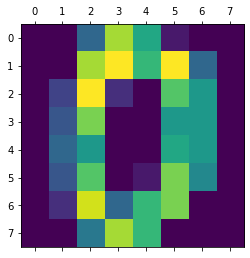

In [18]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
digits = load_digits()   #load the dataset from sklearn
images = digits.images
datas = digits.data
targets = digits.target

print('Size of images is:')
print(images.shape)
print('Size of datas is:')
print(datas.shape)
print('Size of targets is:')
print(targets.shape)

plt.matshow(images[0]) 
plt.show()

We need to standardize those inputs to $(-1, 1)$ first so that it will help the training of ANN convergent. We will use the function **StandardScaler** from sklearn to help us scaling the inputs.

In [19]:
from sklearn.preprocessing import StandardScaler
InputScaling = StandardScaler()
transX = InputScaling.fit_transform(datas)
print(transX[0][:5])

[ 0.         -0.33501649 -0.04308102  0.27407152 -0.66447751]


However, we do not use 0-9 integers in the ANN as output, instead, we use an one-hot vector of lenth 10 to indicate the corresponding digits. By the word **one-hot** I mean it's a binary vector with only one element of which is 1 and others are 0. For example, I can use vector **[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]** to indicate digit 1, and use **[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]** to indicate digit 3. So I need to write a function to transform those targets into one-hot vectors.

In [20]:
import numpy as np
def num2vect(y):
    y_vect = np.zeros((len(y), 10))
    for i in range(len(y)):
        y_vect[i, y[i]] = 1
    return y_vect
transy = num2vect(targets)
print('The label of the image above is transformed to:')
print(y[0])

The label of the image above is transformed to:
Tensor("strided_slice:0", shape=(10,), dtype=float32)


Now we are going to use a function **train_test_split** from sklearn to randomly choose some elements in **datas** and **targets** as traning set and make the remains as test set.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(transX, transy, test_size=0.3)
print(X_train.shape)
print(X_train[0][0:5])
print(y_train.shape)
print(y_train[0])

(1257, 64)
[ 0.         -0.33501649 -1.09493684  0.98034282 -1.13109185]
(1257, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Since we will use batch gradient descent approach to optimise those parameters(variables) in the neural network, we need to write a function to randomly chose a batch of samples from our training set.

In [22]:
def next_random_batch(batchSize, X, y):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(X))
    np.random.shuffle(idx)
    idx = idx[:batchSize]
    X_shuffle = [X[i] for i in idx]
    y_shuffle = [y[i] for i in idx]
    return np.asarray(X_shuffle), np.asarray(y_shuffle)

Here is a small demo of how the function **next_random_batch** work:

In [23]:
btest_X = np.arange(0, 18).reshape(6, 3)
btest_y = np.arange(0, 24).reshape(6, 4)
batch_X, batch_y = next_random_batch(3, btest_X, btest_y)
print('Test set X is:')
print(btest_X)
print('Their corresponding label is:')
print(btest_y)
print('X in a batch is')
print(batch_X)
print('Their corresponding label is:')
print(batch_y)

Test set X is:
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
Their corresponding label is:
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]
 [20 21 22 23]]
X in a batch is
[[ 3  4  5]
 [15 16 17]
 [ 6  7  8]]
Their corresponding label is:
[[ 4  5  6  7]
 [20 21 22 23]
 [ 8  9 10 11]]


## Run the ANN with Tensorflow Session()
Now we have all the preparation, we will run the training process(the optimisation operation) to train an ANN to perform digits recognition.

In [24]:
NN_name = 'mnist_ann'
epoch = 10
batchSize = 100
batchNum = int(datas.shape[0] / batchSize)
with tf.Session() as sess:
    sess.run(init)
    #Start training
    for e in range(epoch):
        for b in range(batchNum):
            mean_ce = 0
            XBatch, yBatch = next_random_batch(batchSize, X_train, y_train)
            ce, _ = sess.run([cross_entropy, optimiser], feed_dict = {X: XBatch, y: yBatch})
            mean_ce += ce/batchNum
        print('Epoch %d finished! Cross entropy is %f'%(epoch + 1, mean_ce))
    # Validation
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_, 1), tf.argmax(y, 1)), tf.float32))
    acc = sess.run(accuracy, feed_dict = {X: X_test, y: y_test})
    print('The recognition accuracy in the testset is %f'%(acc))
    
    #Save model
    file_path= './'+ NN_name + '/'
    if not os.path.exists(file_path):
        os.mkdir(file_path)
    saver = tf.train.Saver()
    saver.save(sess, file_path+ 'model.checkpoint')
    print('Model saved')

Epoch 11 finished! Cross entropy is 0.084075
Epoch 11 finished! Cross entropy is 0.017558
Epoch 11 finished! Cross entropy is 0.007733
Epoch 11 finished! Cross entropy is 0.011397
Epoch 11 finished! Cross entropy is 0.005167
Epoch 11 finished! Cross entropy is 0.003343
Epoch 11 finished! Cross entropy is 0.002296
Epoch 11 finished! Cross entropy is 0.001973
Epoch 11 finished! Cross entropy is 0.001973
Epoch 11 finished! Cross entropy is 0.000977
The recognition accuracy in the testset is 0.972222
Model saved


## Recognise digits with the trained ANN model

Model loaded
The real digit is 0
Recognised as 0


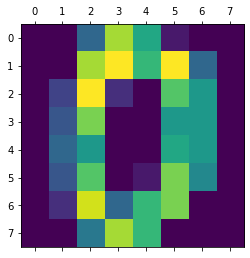

In [26]:
NN_name = 'mnist_ann'
i = 0
digData = transX[i][np.newaxis, :]
diglabel = transy[i][np.newaxis, :]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_path = './' + NN_name + '/'
    saver = tf.train.Saver()
    saver.restore(sess, file_path+ 'model.checkpoint')
    print('Model loaded')
    vec_rec = sess.run(y_, feed_dict = {X: digData})
    y_rec = np.argmax(vec_rec)
    print('The real digit is %d'%(np.argmax(diglabel)))
    print('Recognised as %d'%(y_rec))
    plt.matshow(images[i]) 

In [27]:
ad = np.array([1,2,3,4,5])[np.newaxis, :]
ad

array([[1, 2, 3, 4, 5]])

Model loaded
The real digit is 1
Recognised as 1


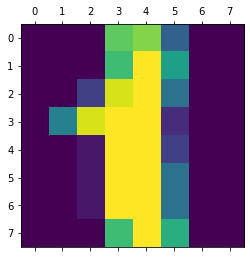

In [28]:
NN_name = 'mnist_ann'
i = 1
digData = transX[i][np.newaxis, :]
diglabel = transy[i][np.newaxis, :]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_path = './' + NN_name + '/'
    saver = tf.train.Saver()
    saver.restore(sess, file_path+ 'model.checkpoint')
    print('Model loaded')
    vec_rec = sess.run(y_, feed_dict = {X: digData})
    y_rec = np.argmax(vec_rec)
    print('The real digit is %d'%(np.argmax(diglabel)))
    print('Recognised as %d'%(y_rec))
    plt.matshow(images[i]) 

Model loaded
The real digit is 2
Recognised as 2


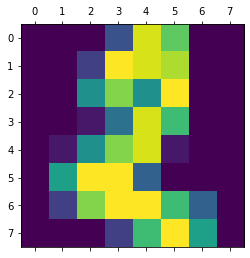

In [29]:
NN_name = 'mnist_ann'
i = 2
digData = transX[i][np.newaxis, :]
diglabel = transy[i][np.newaxis, :]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_path = './' + NN_name + '/'
    saver = tf.train.Saver()
    saver.restore(sess, file_path+ 'model.checkpoint')
    print('Model loaded')
    vec_rec = sess.run(y_, feed_dict = {X: digData})
    y_rec = np.argmax(vec_rec)
    print('The real digit is %d'%(np.argmax(diglabel)))
    print('Recognised as %d'%(y_rec))
    plt.matshow(images[i]) 

Model loaded
The real digit is 3
Recognised as 3


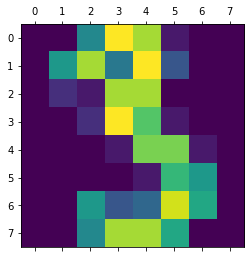

In [30]:
NN_name = 'mnist_ann'
i = 3
digData = transX[i][np.newaxis, :]
diglabel = transy[i][np.newaxis, :]
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_path = './' + NN_name + '/'
    saver = tf.train.Saver()
    saver.restore(sess, file_path+ 'model.checkpoint')
    print('Model loaded')
    vec_rec = sess.run(y_, feed_dict = {X: digData})
    y_rec = np.argmax(vec_rec)
    print('The real digit is %d'%(np.argmax(diglabel)))
    print('Recognised as %d'%(y_rec))
    plt.matshow(images[i]) 